In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.optimize import minimize
import os
import cma

matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams['figure.figsize'] = [17, 17]

# Male, Female or Total, studied gender of the mortality data
gender = "Total"

# cohort or population, type of study
data_type = "population"

# studied country
country = "France"

# studied year
year = 1951

# Path to where the desired data is located
data_path = "./mortality_data/"+data_type+"/"+country+"_"+data_type+"_mortality.txt"

# age at which the data used to fit the model stops
age_stop = 65

# age at which the data used to evaluate the fit stops
age_stop_test = 65

# function computing the contribution of aging to the hazard rate
@np.vectorize
def aging_gompertz_makaham(x, a, b, c):
    return c + a*np.exp((b*x))

# function computing the contribution of learning to the hazard rate
@np.vectorize
def learning(x, Lmax, k_learning, n):
    return (Lmax/(1 + np.exp(n*(x-k_learning)))) - Lmax

# function computing the contribution of growth to the hazard rate
@np.vectorize
def growth(x, Gmax, growth_speed):
    results = []
    if (x < 30):
        results.append(Gmax/(1 + x**growth_speed) - Gmax ) 
    else : 
        results.append(Gmax/(1 + 30**growth_speed) - Gmax ) 
    return np.array(results)

# function summing all the contributions and returning the log of this sum. 
@np.vectorize
def log_mortality_gompertz_makaham(x, a, b, c, Lmax, k_learning, n, Gmax, growth_speed):
    res = aging_gompertz_makaham(x, a, b, c) + learning(x, Lmax, k_learning, n) + growth(x, Gmax, growth_speed)
    if res > 0 : 
        return np.log10(res)
    else :
        return np.log10(1.)

# cost function used for fitting
def errlearning_gompertz_makaham(params, x, y, weights, lm=0, ord=0):
    from numpy.linalg import norm
    a, b, c, Lmax, k_learning, n, Gmax, growth_speed = params

    # penalization for negative values
    if any(e<0 for e in params) == True:
        return 100

    err = norm(weights*(log_mortality_gompertz_makaham(x, a, b, c, Lmax, k_learning, n, Gmax, growth_speed) - y))
    return err + lm * norm(params, ord)

# function used for computing the s measure (average distance between the data and the fitted model in %)
def s_measure(pred, data):
    distance = np.absolute(pred - data)
    distance_percentage = (distance/np.absolute(data))*100
    return np.mean(distance_percentage)
    # return np.average(distance_percentage, weights=weights)


# fitting function using the minimize method from scipy
def fit(x, mortality_array, guess, bounds):

    # weight computation, can sometimes improve the fit but may also impact it negatively
    lx = [10000]
    for i in range(1, mortality_array.shape[0]):
        lx.append(lx[i-1]-lx[i-1]*mortality_array[i])
    lx = np.array(lx)
    surviving_fraction = lx/lx[0]
    surviving_fraction = np.square(surviving_fraction)

    # comment this line to use the computed weights
    surviving_fraction = np.ones_like(surviving_fraction)

    params = minimize(errlearning_gompertz_makaham, guess, method="SLSQP", tol = 1e-15, args=(x, np.log10(mortality_array), surviving_fraction, 1e-4, 2), bounds = bounds)
    return params.x

# fitting function using the CMA method, more accurate but slower than the one using minimize from scipy
def fit_cma(x, mortality_array, sigma):
    lx = [10000]
    for i in range(1, mortality_array.shape[0]):
        lx.append(lx[i-1]-lx[i-1]*mortality_array[i])
    lx = np.array(lx)
    surviving_fraction = lx/lx[0]
    surviving_fraction = np.square(surviving_fraction)
    surviving_fraction = np.ones_like(surviving_fraction)
    global f 
    def f(params):
        return errlearning_gompertz_makaham(params, x, np.log10(mortality_array), surviving_fraction)

    es = cma.CMAEvolutionStrategy([4.76614499e-03, 2.29715390e-02, 1.87466206e-02, 5.58711082e-03, 3.63829644e+01, 1.38484469e-01, 4.34710796e-02, 0.1], sigma)
    es.optimize(f, iterations=5000, n_jobs=-1)
    return es

In [4]:
# read text file into pandas DataFrame
base_dataframe = pd.read_csv(data_path, sep=" ")

# selects desired gender
base_dataframe = base_dataframe[['Year', 'Age', gender]]

# selects desired year
base_dataframe = base_dataframe[base_dataframe['Year'] == year]

# removes the 110+ data line for the mortality data
base_dataframe = base_dataframe[~(base_dataframe['Age'] == "110+")]

# converts the Year and Age column to integers
base_dataframe = base_dataframe.astype({"Year" : int, "Age" : int})


df1 = base_dataframe[base_dataframe['Age'] <= age_stop]
df1 = df1.astype(float)

df1_test = base_dataframe[base_dataframe['Age'] <= age_stop_test]
df1_test = df1_test.astype(float)

beg = 0 #starting x 
fin = age_stop #final x
steps = age_stop+1
x = np.linspace(beg, fin, steps)
x_test = np.linspace(beg, age_stop_test, age_stop_test+1)

# initial guess and bounds for the fitting
guess = [4.17399393e-03, 4.29746495e-02, 2.86076474e-02, 3.91364426e-02, 4.61448543e+01, 8.85350563e-02, 5.92916574e-02, 0.1]
bounds = ((0,1),(0,1),(0,1),(0,1),(0,90),(0,3),(0,1), (0, 1))

dataframe = df1[df1['Year'] == year]
dataframe = dataframe[gender]
mortality_array = dataframe.to_numpy().squeeze()

dataframe_test = df1_test[df1_test['Year'] == year]
dataframe_test = dataframe_test[gender]
mortality_array_test = dataframe_test.to_numpy().squeeze()

# fitting with CMA
es = fit_cma(x, mortality_array, 0.005)
params_cma = es.result.xfavorite

# fitting with scipy.minimize
params_scipy = fit(x_test, mortality_array_test, guess, bounds)

pred_cma = log_mortality_gompertz_makaham(x_test, params_cma[0], params_cma[1], params_cma[2], params_cma[3], params_cma[4], params_cma[5], params_cma[6], params_cma[7])

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 8 (seed=176404, Thu Jan 19 10:32:01 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.737583587171189e+00 1.0e+00 5.12e-03  5e-03  5e-03 0:00.0
    2     20 3.795532971407732e+00 1.3e+00 5.36e-03  5e-03  6e-03 0:00.0
    3     30 2.924171058793597e+00 1.5e+00 5.21e-03  5e-03  6e-03 0:00.1
  100   1000 5.337004620128378e-01 1.2e+02 1.11e-03  2e-04  2e-03 0:01.8
  200   2000 2.986127665097182e-01 6.7e+02 1.28e-03  1e-04  2e-03 0:03.4
  300   3000 2.796318033430003e-01 3.0e+03 5.54e-04  3e-05  8e-04 0:05.1
  400   4000 2.788350742733468e-01 7.3e+03 8.00e-04  2e-05  1e-03 0:06.7
  500   5000 2.772710474771416e-01 1.2e+05 1.04e-02  8e-05  7e-02 0:08.4
  600   6000 2.766569342417403e-01 1.5e+05 7.00e-03  2e-05  2e-02 0:10.0
  700   7000 2.765074156283686e-01 1.4e+05 2.08e-02  3e-05  2e-02 0:11.6
  800   8000 2.765031740189671e-01 4.0e+05 1.39e-05  7e-09  8e-06 0:13.2
  813   8130 2.765031740187389e-01

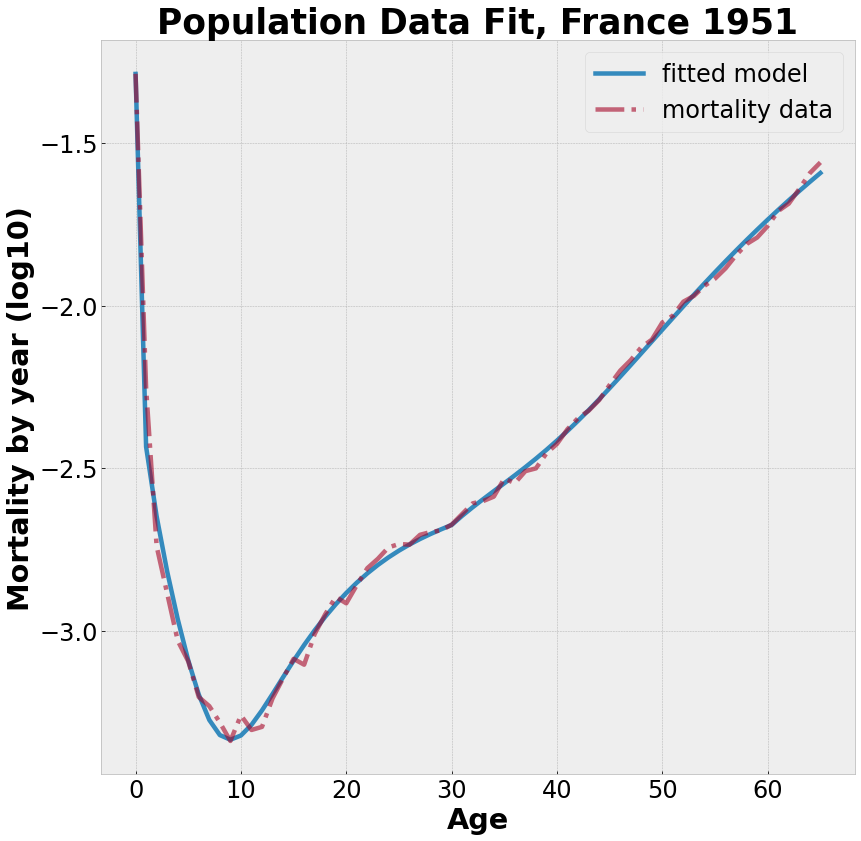

In [5]:
# Plot of the CMA results
with plt.style.context("bmh"):
    fig, ax = plt.subplots()
    fig.set_size_inches(13.5, 13.5)
    ax.plot(pred_cma, linewidth=4.5)
    ax.set_xlabel("Age", fontweight="bold")
    ax.set_ylabel("Mortality by year (log10)", fontweight="bold")
    ax.plot(np.log10(mortality_array_test), '-.', alpha=0.6, linewidth=4.5)
    title = "Population Data Fit, " + country + " " + str(year)
    ax.set_title(title, fontweight="bold")
    ax.legend(["fitted model", "mortality data"])
    fig.show()
    path = "/home/spsalmon/images_for_paper/"+country+"_"+str(year)+"_"+data_type+"_fit.png"
    # fig.savefig(path, dpi=300)

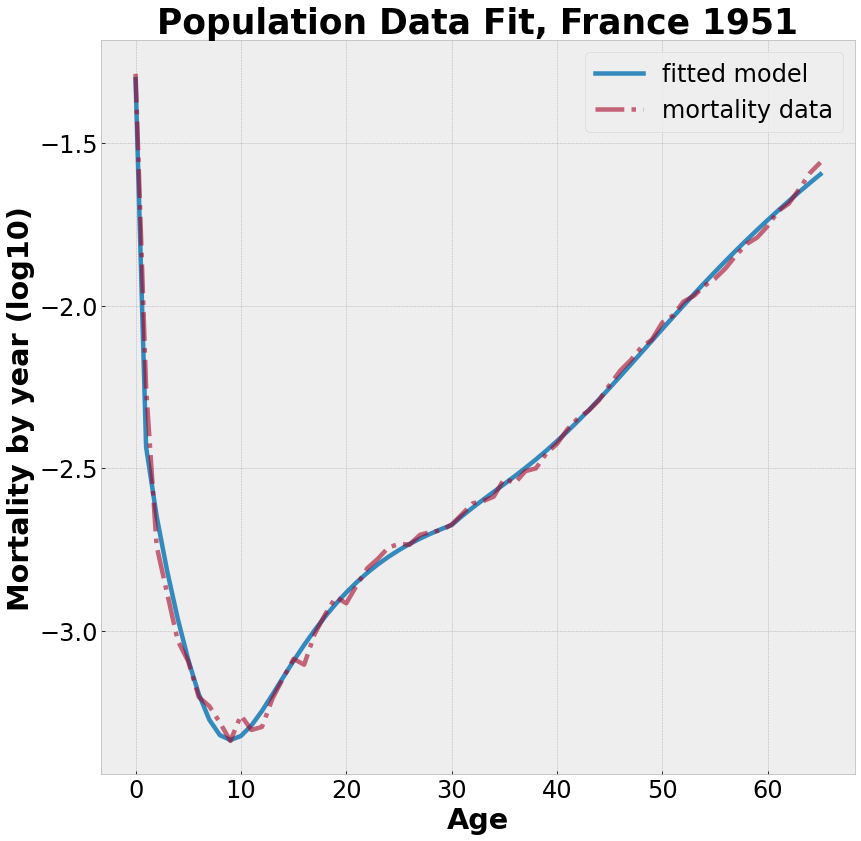

In [6]:
pred_scipy = log_mortality_gompertz_makaham(x_test, params_scipy[0], params_scipy[1], params_scipy[2],  params_scipy[3], params_scipy[4], params_scipy[5], params_scipy[6], params_scipy[7])

# Plot of the scipy.minize results
with plt.style.context("bmh"):
    fig, ax = plt.subplots()
    fig.set_size_inches(13.5, 13.5)
    ax.plot(pred_scipy, linewidth=4.5)
    ax.set_xlabel("Age", fontweight="bold")
    ax.set_ylabel("Mortality by year (log10)", fontweight="bold")
    ax.plot(np.log10(mortality_array_test), '-.', alpha=0.6, linewidth=4.5)
    title = "Population Data Fit, " + country + " " + str(year)
    ax.set_title(title, fontweight="bold")
    ax.legend(["fitted model", "mortality data"])
    fig.show()
    path = "/home/spsalmon/images_for_paper/"+country+"_"+str(year)+"_"+data_type+"_fit.png"
    # fig.savefig(path, dpi=300)

In [7]:
# Comparison between scipy.minize and CMA

print("s_measure of the CMA fit :", s_measure(pred_cma, np.log10(mortality_array_test)))
print("s_measure of the scipy.minimize fit :", s_measure(pred_scipy, np.log10(mortality_array_test)))

s_measure of the CMA fit : 0.8393660776483138
s_measure of the scipy.minimize fit : 0.8504894770501582
